In [5]:
!pip install keras

In [30]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


## Load Data

- NLTK 库有许多包含单词及其词性标签的语料库

In [8]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus
# let's look at the data
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

## Divide data in words (X) and tags (Y)

- 由于这是一个多对多问题，因此每个数据点将是语料库的不同句子。
- 每个数据点在输入序列中都会有多个单词,也就是X。
- 每个单词在输出序列中都会有其对应的标签,也就是Y。

In [9]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag

    X.append(X_sentence)
    Y.append(Y_sentence)

In [10]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [11]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [12]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [13]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


## Vectorise X and Y

- 使用 Keras 库中的 Tokenizer() 函数将文本序列编码为整数序列

In [14]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [15]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [16]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [17]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences

- 定义序列长度
- 到目前为止，数据中存在的句子的长度各不相同
- 需要填充短句子或将长句子截断为固定长度
- 固定长度是一个超参数

In [18]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


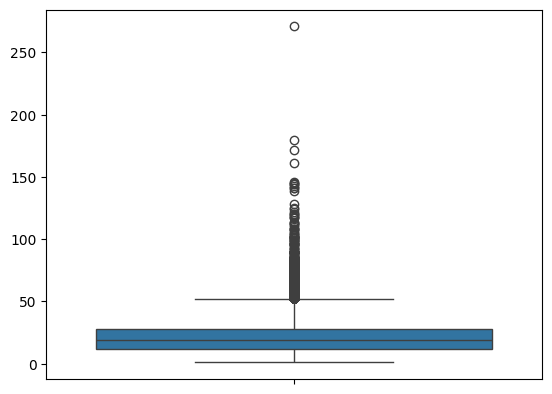

In [19]:
sns.boxplot(lengths)
plt.show()

In [20]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function.
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'.
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [21]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [22]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word embeddings

### Use word embeddings for input sequences (X)

In [24]:
# word2vec download link (Size ~ 1.5GB): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

path = '/content/drive/MyDrive/DT-NLP-2024/Lesson9/GoogleNews-vectors-negative300.bin.gz'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [25]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [26]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [27]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [28]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

### Use one-hot encoding for output sequences (Y)

In [31]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [32]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 100, 13)


## Split data in training, validation and tesing sets

In [33]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


- 需要注意的是
- 在使用 RNN 之前，必须确保数据的维度是 RNN 所期望的。一般来说,RNN 模型输入输出的要求如下:

- Shape of X: (#samples, #timesteps, #features)

- Shape of Y: (#samples, #timesteps, #features)

## Vanilla RNN

### With uninitialised fixed embeddings

In [34]:
# total number of tags
NUM_CLASSES = Y.shape[2]
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [36]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [37]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDist  (None, 100, 13)           845       
 ributed)                                                        
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 24205 (94.55 KB)
Non-trainable params: 17834700 (68.03 MB)
_________________________________________________________________


In [38]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 49s 117ms/step - loss: 0.4970 - acc: 0.8599 - val_loss: 0.3251 - val_acc: 0.9019
Epoch 2/10
408/408 [==============================] - 41s 99ms/step - loss: 0.2714 - acc: 0.9168 - val_loss: 0.2279 - val_acc: 0.9301
Epoch 3/10
408/408 [==============================] - 48s 117ms/step - loss: 0.2061 - acc: 0.9361 - val_loss: 0.1852 - val_acc: 0.9419
Epoch 4/10
408/408 [==============================] - 55s 135ms/step - loss: 0.1742 - acc: 0.9448 - val_loss: 0.1618 - val_acc: 0.9484
Epoch 5/10
408/408 [==============================] - 50s 121ms/step - loss: 0.1556 - acc: 0.9503 - val_loss: 0.1478 - val_acc: 0.9529
Epoch 6/10
408/408 [==============================] - 51s 125ms/step - loss: 0.1437 - acc: 0.9536 - val_loss: 0.1389 - val_acc: 0.9553
Epoch 7/10
408/408 [==============================] - 41s 101ms/step - loss: 0.1357 - acc: 0.9554 - val_loss: 0.1320 - val_acc: 0.9564
Epoch 8/10
408/408 [==============================] - 39

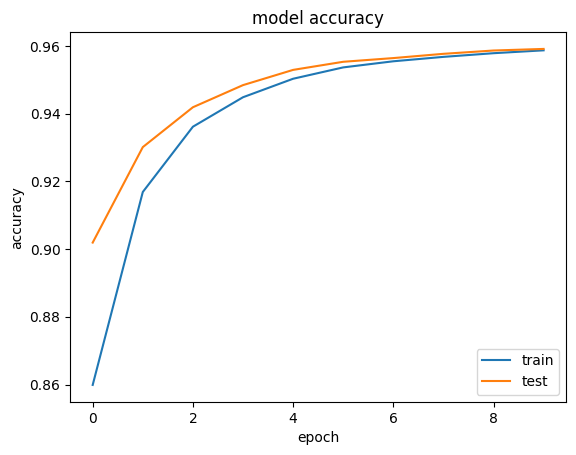

In [39]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### with uninitialised trainable embeddings

In [40]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [41]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 259s 632ms/step - loss: 0.2110 - acc: 0.9497 - val_loss: 0.0403 - val_acc: 0.9879
Epoch 2/10
408/408 [==============================] - 253s 621ms/step - loss: 0.0291 - acc: 0.9906 - val_loss: 0.0294 - val_acc: 0.9897
Epoch 3/10
408/408 [==============================] - 247s 606ms/step - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0275 - val_acc: 0.9902
Epoch 4/10
408/408 [==============================] - 242s 592ms/step - loss: 0.0170 - acc: 0.9939 - val_loss: 0.0273 - val_acc: 0.9904
Epoch 5/10
408/408 [==============================] - 264s 648ms/step - loss: 0.0147 - acc: 0.9947 - val_loss: 0.0278 - val_acc: 0.9903
Epoch 6/10
408/408 [==============================] - 235s 577ms/step - loss: 0.0128 - acc: 0.9955 - val_loss: 0.0289 - val_acc: 0.9902
Epoch 7/10
408/408 [==============================] - 236s 579ms/step - loss: 0.0109 - acc: 0.9962 - val_loss: 0.0305 - val_acc: 0.9900
Epoch 8/10
408/408 [============================

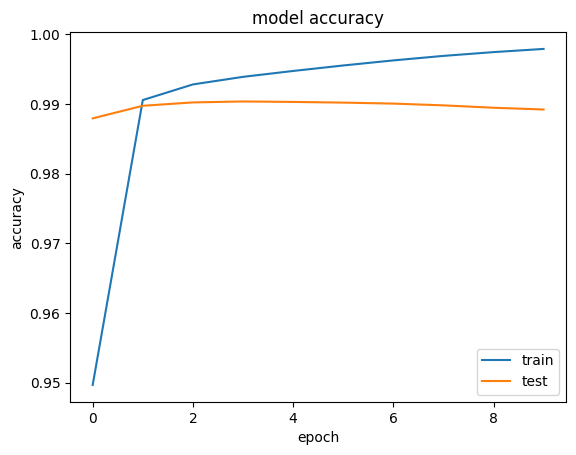

In [43]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Using pre-trained embedding weights

In [44]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [45]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 230s 562ms/step - loss: 0.1842 - acc: 0.9602 - val_loss: 0.0357 - val_acc: 0.9888
Epoch 2/10
408/408 [==============================] - 232s 569ms/step - loss: 0.0274 - acc: 0.9909 - val_loss: 0.0275 - val_acc: 0.9904
Epoch 3/10
408/408 [==============================] - 228s 559ms/step - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0256 - val_acc: 0.9908
Epoch 4/10
408/408 [==============================] - 231s 567ms/step - loss: 0.0173 - acc: 0.9937 - val_loss: 0.0251 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 231s 565ms/step - loss: 0.0153 - acc: 0.9945 - val_loss: 0.0250 - val_acc: 0.9911
Epoch 6/10
408/408 [==============================] - 228s 559ms/step - loss: 0.0136 - acc: 0.9951 - val_loss: 0.0254 - val_acc: 0.9912
Epoch 7/10
408/408 [==============================] - 229s 562ms/step - loss: 0.0120 - acc: 0.9957 - val_loss: 0.0262 - val_acc: 0.9910
Epoch 8/10
408/408 [============================

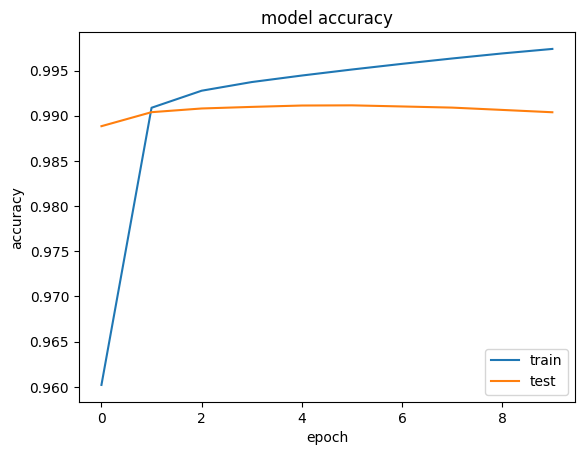

In [47]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## LSTM Model

In [48]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [49]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17928985 (68.39 MB)
Trainable params: 17928985 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 306s 742ms/step - loss: 0.3027 - acc: 0.9310 - val_loss: 0.0463 - val_acc: 0.9871
Epoch 2/10
408/408 [==============================] - 304s 745ms/step - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0298 - val_acc: 0.9899
Epoch 3/10
408/408 [==============================] - 305s 748ms/step - loss: 0.0236 - acc: 0.9918 - val_loss: 0.0262 - val_acc: 0.9907
Epoch 4/10
408/408 [==============================] - 306s 750ms/step - loss: 0.0198 - acc: 0.9928 - val_loss: 0.0249 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 314s 768ms/step - loss: 0.0177 - acc: 0.9936 - val_loss: 0.0242 - val_acc: 0.9913
Epoch 6/10
408/408 [==============================] - 314s 770ms/step - loss: 0.0161 - acc: 0.9941 - val_loss: 0.0241 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 309s 756ms/step - loss: 0.0147 - acc: 0.9946 - val_loss: 0.0241 - val_acc: 0.9914
Epoch 8/10
408/408 [============================

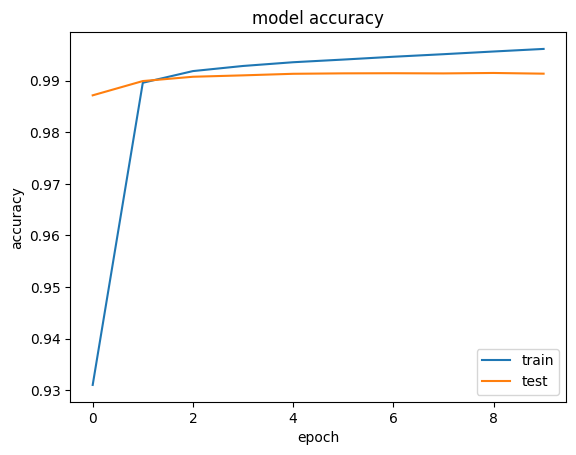

In [51]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## GRU

In [52]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [53]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17905817 (68.31 MB)
Trainable params: 17905817 (68.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 292s 708ms/step - loss: 0.2227 - acc: 0.9590 - val_loss: 0.0354 - val_acc: 0.9884
Epoch 2/10
408/408 [==============================] - 294s 719ms/step - loss: 0.0274 - acc: 0.9904 - val_loss: 0.0269 - val_acc: 0.9902
Epoch 3/10
408/408 [==============================] - 291s 714ms/step - loss: 0.0207 - acc: 0.9924 - val_loss: 0.0247 - val_acc: 0.9910
Epoch 4/10
408/408 [==============================] - 292s 716ms/step - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0238 - val_acc: 0.9913
Epoch 5/10
408/408 [==============================] - 294s 720ms/step - loss: 0.0162 - acc: 0.9940 - val_loss: 0.0234 - val_acc: 0.9914
Epoch 6/10
408/408 [==============================] - 290s 712ms/step - loss: 0.0148 - acc: 0.9944 - val_loss: 0.0234 - val_acc: 0.9916
Epoch 7/10
408/408 [==============================] - 293s 717ms/step - loss: 0.0136 - acc: 0.9949 - val_loss: 0.0237 - val_acc: 0.9916
Epoch 8/10
408/408 [============================

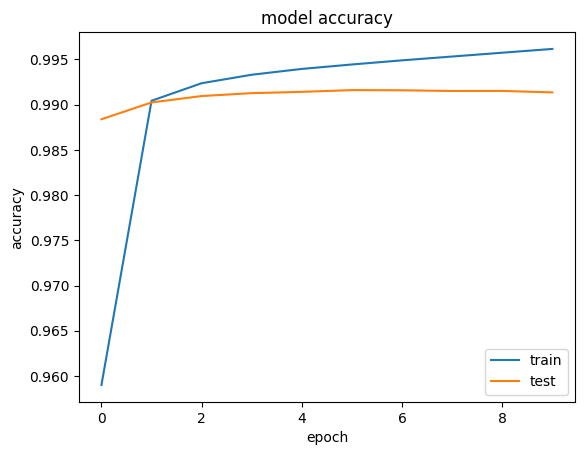

In [55]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Bidirectional LSTM

In [56]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [57]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [58]:
# check summary of model
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          186880    
 al)                                                             
                                                                 
 time_distributed_5 (TimeDi  (None, 100, 13)           1677      
 stributed)                                                      
                                                                 
Total params: 18023257 (68.75 MB)
Trainable params: 18023257 (68.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 439s 1s/step - loss: 0.2249 - acc: 0.9473 - val_loss: 0.0309 - val_acc: 0.9905
Epoch 2/10
408/408 [==============================] - 438s 1s/step - loss: 0.0229 - acc: 0.9926 - val_loss: 0.0215 - val_acc: 0.9928
Epoch 3/10
408/408 [==============================] - 432s 1s/step - loss: 0.0155 - acc: 0.9949 - val_loss: 0.0191 - val_acc: 0.9935
Epoch 4/10
408/408 [==============================] - 435s 1s/step - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0182 - val_acc: 0.9939
Epoch 5/10
408/408 [==============================] - 436s 1s/step - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0181 - val_acc: 0.9940
Epoch 6/10
408/408 [==============================] - 429s 1s/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0182 - val_acc: 0.9941
Epoch 7/10
408/408 [==============================] - 427s 1s/step - loss: 0.0065 - acc: 0.9980 - val_loss: 0.0189 - val_acc: 0.9940
Epoch 8/10
408/408 [==============================] - 434s 1s/step - 

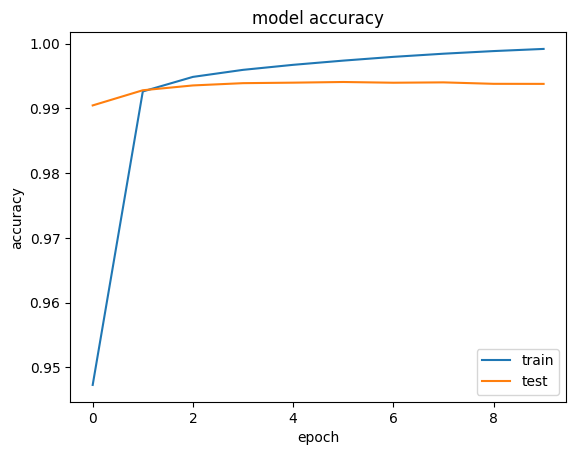

In [60]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Model Evaluation

In [61]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 6s 18ms/step - loss: 0.0304 - acc: 0.9905
Loss: 0.03035086579620838,
Accuracy: 0.990483820438385


In [62]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 15s 45ms/step - loss: 0.0254 - acc: 0.9915
Loss: 0.025377638638019562,
Accuracy: 0.9915344715118408


In [63]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 13s 38ms/step - loss: 0.0256 - acc: 0.9914
Loss: 0.025605950504541397,
Accuracy: 0.9914384484291077


In [64]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 28s 82ms/step - loss: 0.0229 - acc: 0.9938
Loss: 0.022892778739333153,
Accuracy: 0.9937780499458313
